<a href="https://colab.research.google.com/github/HammadSheharyar/Hammad_BEE12C-Automated-Electronic-Component-Identification/blob/main/Electronic_Components_image_classifier_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification: Dense Neural Network

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/computer-vision-with-embedded-machine-learning/blob/master/1.2.3%20-%20Training%20an%20Image%20Classifier%20with%20Keras/image_classifier_dnn.ipynb)

Run this notebook to train a dense neural network (DNN) on your own image dataset.

Based on: https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb#scrollTo=rFFriuVPwhAm

(I recommend working through the example above, as it has a lot of good descriptions on doing classification with images)

Create a folder named "dataset" in the /content directory and upload your images there. The images should be divided into their respective classes, where each class has its own folder with the name of the class. For example:

<pre>
/content
    |- dataset
        |- background
        |- capacitor
        |- diode
        |- led
        |- resistor
</pre>

Author: EdgeImpulse, Inc.<br>
Date: June 5, 2021<br>
License: [Apache-2.0](apache.org/licenses/LICENSE-2.0)<br>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import PIL

from keras import utils                                   # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers import Dense, Dropout, Activation       # Types of layers we wish to use

from skimage.transform import resize                      # Used to scale/resize image arrays

from sklearn.metrics import confusion_matrix              # Used to quickly make confusion matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
### Settings

# Location of dataset
DATASET_PATH = "/content/drive/MyDrive/Electronic-Components-Data/electronic-components-bmp"

# Desired resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# Invert image (dark backgrounds can sometimes improve accuracy)
INVERT = False

# Set aside 20% for validation and 20% for test
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# You are welcome to change the seed to try a different validation set split
random.seed(42)

In [60]:
### Load images as Numpy arrays

# We want to record the labels and assign a ground truth label as a number to each sample
labels = []
y_all = []    # Lowercase 'y' - 1D vector of the ground labels (n)
X_all = []    # Uppercase 'X' - 3D array of all image samples (n x width x height)

# Find the directories in the dataset folder (skip the Jupyter Notebook checkpoints hidden folder)
for label in os.listdir(DATASET_PATH):
  class_dir = os.path.join(DATASET_PATH, label)
  if os.path.isdir(class_dir) and label != ".ipynb_checkpoints":

    # Add the name of the folder to our labels list
    labels.append(label)

    # Go through each image in the folder
    for i, file in enumerate(os.listdir(class_dir)):

      # Skip the Jupyter Notebook checkpoints folder that sometimes gets added
      if file != ".ipynb_checkpoints":

        # Open image and convert to grayscale
        file_path = os.path.join(class_dir, file)
        img = PIL.Image.open(file_path).convert('L')

        # Convert the image to a Numpy array, optionally invern, and append to X
        img_array = np.asarray(img)
        if INVERT:
          img_array = 255 - img_array
        X_all.append(img_array)

        # Add label to the y array
        y_all.append(label)

    # Show how many images we loaded
    print("Added", str(i + 1), "images from", label)

# Calculate total number of samples
num_samples = len(X_all)

# Sort the labels list by alphabetical order
labels = sorted(labels)

# Print out labels and number of samples
print(labels)
print("Number of samples:", num_samples)

Added 50 images from capacitor
Added 50 images from resistor
Added 50 images from diode
Added 60 images from led
Added 50 images from background
['background', 'capacitor', 'diode', 'led', 'resistor']
Number of samples: 260


In [61]:
### Convert labels to numbers

# Show the labels before the conversion
print("Before:", y_all)

# Convert each label to its index in the labels
y_out = []
for i, label in enumerate(y_all):
  y_out.append(labels.index(label))
y_all = y_out

# Show the labels after the conversion
print("After:", y_all)

Before: ['capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resi

In [62]:
### Shuffle samples and labels together, divide into test, validation, and training sets

# Shuffle samples and associated labels together
X_y = list(zip(X_all, y_all))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)
num_samples_val = int(VAL_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The next `num_samples_val` samples of the shuffled list becomes the validation set
X_val = X_all[num_samples_test:(num_samples_test + num_samples_val)]
y_val = y_all[num_samples_test:(num_samples_test + num_samples_val)]

# The remaining samples become the training set
X_train = X_all[(num_samples_test + num_samples_val):]
y_train = y_all[(num_samples_test + num_samples_val):]

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test, validation, and training samples
print("Number of test samples:", num_samples_test)
print("Number of validation samples:", num_samples_val)
print("Number of training samples:", num_samples_train)

Number of test samples: 52
Number of validation samples: 52
Number of training samples: 156


Label: 4 (resistor)
[[146 146 146 ... 152 152 152]
 [146 146 146 ... 152 152 152]
 [146 146 146 ... 151 151 151]
 ...
 [146 146 146 ... 154 157 157]
 [146 146 146 ... 157 157 157]
 [146 146 146 ... 157 157 157]]


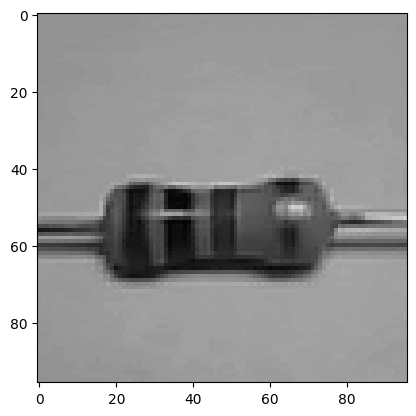

In [63]:
### View one of the training samples

# Chose which sample you want to view
idx = 100

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)

In [64]:
### Function to resize list of images
def resize_images(images, width, height, anti_aliasing=True):
  """
  Prove a list of Numpy arrays (in images parameter) to have them all resized to desired height and
  width. Returns the list of newly resized image arrays.

  NOTE: skimage resize returns *normalized* image arrays (values between 0..1)
  """
  X_out = []
  for i, img in enumerate(images):
    X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
  return X_out

In [65]:
### Scale/crop images

# Resize (scale) all images in the training set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the validation set
X_val = resize_images(X_val, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the test set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)

Label: 4 (resistor)
First row: [[0.57254902 0.57254906 0.57254919 0.57254906 0.57254991 0.57258926
  0.57262079 0.57668466 0.58541374 0.58874271 0.59170267 0.59316073
  0.59262749 0.5963589  0.59612938 0.59618406 0.59673843 0.59631901
  0.5963613  0.59630687 0.59935553 0.60014923 0.59790341 0.59612089
  0.59628674 0.59722954 0.59567951 0.5939955 ]]


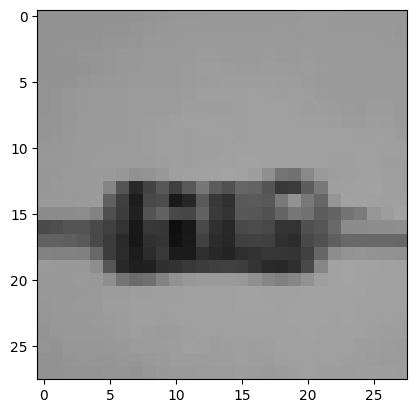

In [66]:
### View training sample again (after they all have been scaled)

# Chose which sample you want to view
idx = 100

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print("First row:", X_train[idx][:1,:])

# Display image from array (note that images have been normalized)
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=1)

In [67]:
### Convert list of samples and labels into Numpy arrays

# Training set
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Validation set
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

# Test set
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Training y:", y_train.shape)
print("Validation X:", X_val.shape)
print("Validation y:", y_val.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Training X: (156, 28, 28)
Training y: (156,)
Validation X: (52, 28, 28)
Validation y: (52,)
Test X: (52, 28, 28)
Test y: (52,)


In [68]:
### Flatten each image to a 1D vector (DNN requires 1D input)

# Compute length of 1D array that we will flatten each image to
len_vector = TARGET_WIDTH * TARGET_WIDTH

# Flatten matricies to vectors
X_train = X_train.reshape(num_samples_train, len_vector)
X_val = X_val.reshape(num_samples_val, len_vector)
X_test = X_test.reshape(num_samples_test, len_vector)

# Determine the input shape for our Keras model (must be tuple)
input_shape = (X_train.shape[1],)

# Print out shapes
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X val:", X_val.shape)
print("y val:", y_val.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)
print("Input tensor shape:", input_shape)

X train: (156, 784)
y train: (156,)
X val: (52, 784)
y val: (52,)
X test: (52, 784)
y test: (52,)
Input tensor shape: (784,)


In [69]:
### Convert labels (integers) to one-hot encoding

# Get number of classes
num_classes = len(labels)

# Use Keras's np_utils to create one-hot encoding (note the capital 'Y' - 2D array)
Y_train = utils.to_categorical(y_train, num_classes)
Y_val = utils.to_categorical(y_val, num_classes)
Y_test = utils.to_categorical(y_test, num_classes)

# Print out shapes (capital 'Y' is our one-hot matrix!)
print("Y train:", Y_train.shape)
print("Y val:", Y_val.shape)
print("Y test:", Y_test.shape)

# Print out a few examples from training set
for i in range(10):
  print("Label: " + str(y_train[i]) + " | One-hot:", Y_train[i])

Y train: (156, 5)
Y val: (52, 5)
Y test: (52, 5)
Label: 0 | One-hot: [1. 0. 0. 0. 0.]
Label: 0 | One-hot: [1. 0. 0. 0. 0.]
Label: 0 | One-hot: [1. 0. 0. 0. 0.]
Label: 2 | One-hot: [0. 0. 1. 0. 0.]
Label: 2 | One-hot: [0. 0. 1. 0. 0.]
Label: 0 | One-hot: [1. 0. 0. 0. 0.]
Label: 4 | One-hot: [0. 0. 0. 0. 1.]
Label: 1 | One-hot: [0. 1. 0. 0. 0.]
Label: 3 | One-hot: [0. 0. 0. 1. 0.]
Label: 3 | One-hot: [0. 0. 0. 1. 0.]


In [70]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [71]:
### Train the model
history = model.fit(X_train,
                    Y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val, Y_val))

Epoch 1/200
5/5 [==============================] - 1s 51ms/step - loss: 1.6951 - acc: 0.1731 - val_loss: 1.5369 - val_acc: 0.5577
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5975 - acc: 0.3077 - val_loss: 1.5237 - val_acc: 0.3654
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5490 - acc: 0.3397 - val_loss: 1.4973 - val_acc: 0.3654
Epoch 4/200
5/5 [==============================] - 0s 15ms/step - loss: 1.4637 - acc: 0.3846 - val_loss: 1.4390 - val_acc: 0.4423
Epoch 5/200
5/5 [==============================] - 0s 16ms/step - loss: 1.4359 - acc: 0.4167 - val_loss: 1.3601 - val_acc: 0.5000
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4162 - acc: 0.3974 - val_loss: 1.3155 - val_acc: 0.3846
Epoch 7/200
5/5 [==============================] - 0s 15ms/step - loss: 1.3614 - acc: 0.4423 - val_loss: 1.2741 - val_acc: 0.4423
Epoch 8/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2566 - acc: 0.49

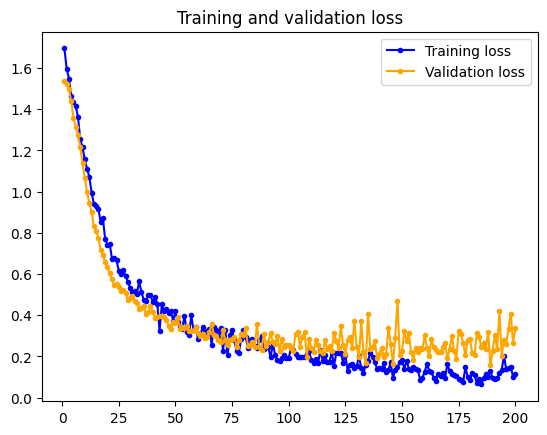

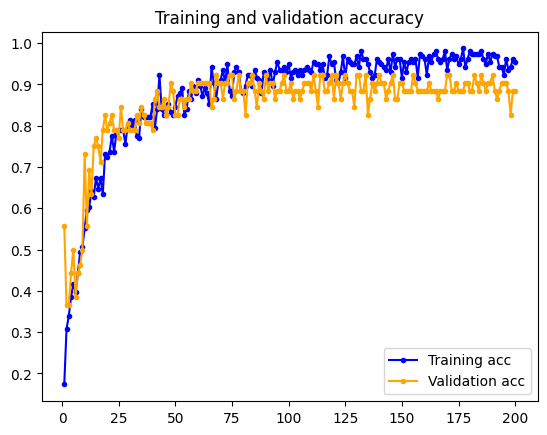

In [72]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [73]:
### Try predicting label with one validation sample (inference)

# Change this to try a different sample from the test set
idx = 0

# Make sample 2D array instead of 1D vector (this is what the Keras model expects as input)
x = np.expand_dims(X_val[idx], 0)

# Make prediction using trained model
y_pred = model.predict(x)

# Find index of highest score in output
predicted_label = np.argmax(y_pred)
actual_label = np.argmax(Y_val[idx])

# Display model output, predicted label, actual label
print("Model output:", y_pred)
print("Predicted label:", predicted_label, "-", labels[predicted_label])
print("Actual label:", actual_label, "-", labels[actual_label])

1/1 [==============================] - 0s 63ms/step
Model output: [[2.2598739e-13 2.6370615e-05 6.8991617e-09 9.9997365e-01 2.9560526e-08]]
Predicted label: 3 - led
Actual label: 3 - led


In [74]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
Y_pred = model.predict(X_val)
print("Validation output shape:", Y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val = np.argmax(Y_val, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val[:50])
print("Predicted validation labels:\t", y_pred[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val, y_pred)
cm = np.transpose(cm)

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))

2/2 [==============================] - 0s 6ms/step
Validation output shape: (52, 5)
Actual validation labels:	 [3 2 4 1 0 3 0 2 2 1 4 4 4 1 2 0 1 0 1 2 1 3 0 3 2 3 4 1 2 3 4 0 4 1 2 1 0
 0 4 1 0 1 3 2 0 1 2 3 4 4]
Predicted validation labels:	 [3 2 2 1 0 3 0 2 2 2 2 4 4 2 2 0 1 0 1 2 1 3 0 3 2 3 4 1 2 3 4 0 4 1 2 1 0
 0 1 1 0 4 3 2 0 1 2 3 4 4]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)   
  background (0):  [    10      0      0      0      0]
   capacitor (1):  [     0     10      0      0      1]
       diode (2):  [     0      2     10      0      2]
         led (3):  [     0      0      0      9      0]
    resistor (4):  [     0      1      0      0      7]


2/2 [==============================] - 0s 7ms/step
Length of y_val: 52
Length of y_pred: 52
Shape of X_val: (52, 784)
Shape of Y_val: (52, 5)
Shape of Y_pred: (52, 5)


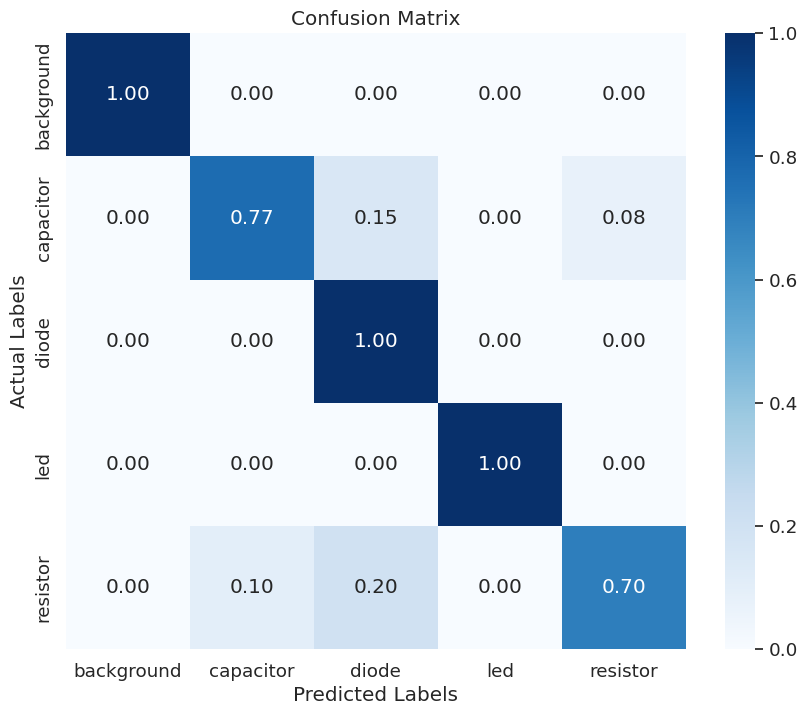

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'labels' is a list of class labels
labels = ["background", "capacitor", "diode", "led", "resistor"]  # replace with your class labels

# Replace Y_val and Y_pred with your actual and predicted validation sets
# Ensure Y_val and Y_pred are one-hot encoded
# Assuming Y_val is a one-hot encoded matrix
Y_val = utils.to_categorical(y_val, num_classes)
# Y_val = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])  # replace with your data
Y_pred = model.predict(X_val)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val = np.argmax(Y_val, axis=1)
y_pred = np.argmax(Y_pred, axis=1)


# Print lengths of y_val and y_pred
print("Length of y_val:", len(y_val))
print("Length of y_pred:", len(y_pred))


print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of Y_pred:", Y_pred.shape)


# Ensure y_val and y_pred have the same length
assert len(y_val) == len(y_pred), "Lengths of y_val and y_pred are inconsistent"

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)




# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Normalize confusion matrix to get percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.set(font_scale=1.2)  # adjust font size
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()



In [75]:
### Evaluate model on validation set
score = model.evaluate(X_val, Y_val)
print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

2/2 [==============================] - 0s 10ms/step - loss: 0.3359 - acc: 0.8846
Validation loss: 0.33592650294303894
Validation accuracy: 0.8846153616905212


In [76]:
### Evaluate model on entire test set
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2/2 [==============================] - 0s 7ms/step - loss: 0.2496 - acc: 0.9038
Test loss: 0.2495708465576172
Test accuracy: 0.9038461446762085


In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Precision
precision = precision_score(y_val, y_pred, average='weighted')

# Recall
recall = recall_score(y_val, y_pred, average='weighted')

# F1 Score
f1 = f1_score(y_val, y_pred, average='weighted')

# Accuracy
accuracy = accuracy_score(y_val, y_pred)

# Print the metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))


Precision: 0.8983
Recall: 0.8846
F1 Score: 0.8835
Accuracy: 0.8846


In [79]:
# Given metrics
precision = 0.8983
recall = 0.8846
f1_score = 0.8835
accuracy = 0.8846

# Convert to percentages
precision_percentage = precision * 100
recall_percentage = recall * 100
f1_score_percentage = f1_score * 100
accuracy_percentage = accuracy * 100

# Print the results
print(f"Precision: {precision_percentage:.2f}%")
print(f"Recall: {recall_percentage:.2f}%")
print(f"F1 Score: {f1_score_percentage:.2f}%")
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Explanation
print("\nExplanation:")
print(f"Precision: Out of all instances predicted as positive, {precision_percentage:.2f}% are correct.")
print(f"Recall: The model identifies approximately {recall_percentage:.2f}% of all actual positive instances.")
print(f"F1 Score: A balanced measure (harmonic mean) of precision and recall, indicating {f1_score_percentage:.2f}% overall performance.")
print(f"Accuracy: Overall correctness of the model across all classes, {accuracy_percentage:.2f}%.")


Precision: 89.83%
Recall: 88.46%
F1 Score: 88.35%
Accuracy: 88.46%

Explanation:
Precision: Out of all instances predicted as positive, 89.83% are correct.
Recall: The model identifies approximately 88.46% of all actual positive instances.
F1 Score: A balanced measure (harmonic mean) of precision and recall, indicating 88.35% overall performance.
Accuracy: Overall correctness of the model across all classes, 88.46%.
